In [305]:
%load_ext autoreload
%autoreload a

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1987]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from tqdm import tqdm
from nba import NBAbase, NBAetl, NBAdata,NBAmodels
from betting import funcs

import shap
from nba_api.stats.endpoints import LeagueDashPtStats

In [1795]:
from sklearn.preprocessing import StandardScaler,RobustScaler
def kellyCrit(prob,odds):
    '''
    Calculates the kelly criterion to help determin betting size, will give as a percentage of bankroll to use
    Inputs: your probability of the event winning, odds (American) that you will be paid out if the win occurs
    Outputs: a float with the amount of your bankroll
    '''
    if odds > 0:
        return prob - (1-prob) / (odds / 100)
    else:
        return prob - (1-prob) / (100/np.abs(odds))
def convertPercentToOdds(x):
    '''
    Take a decimal value and convert that into a US betting odd
    input: float value
    Output: int 
    '''
    if x < .5:
        if x<=.01:
            return 9900
        else:
            return int(100/x -100)
    
    else:
        if x >= .99:
            return -9900
        else:
            return int(1 -(100/(1-x) - 100))
def modTesting(y,ytest,X,Xtest,params,method = None):
    meth = method if method is not None else 'bfgs'
    newMod = sm.MNLogit(endog = np.array(ybin), exog = X.filter(params),)
    upModel = newMod.fit(method = meth,maxiter=1000)
    p = upModel.predict(Xtest.filter(params))
    brierScore(p,ytest,upModel)
    return upModel

def brierScore(p,ytest,model):
    c = sorted(p.columns,reverse=True)
    bscore = np.mean([models.brier_scores(ytest,p,cumlative = True),models.brier_scores(ytest,p)])
    print('Mean Score {:.3f}'.format(bscore))
    print(p.mean().round(3))
    print('\nCumlative Sum of Above')
    print(p.mean().filter(c).cumsum().round(3))
    plt.figure(figsize=(24,16))
    sns.heatmap(model.pvalues.sort_index(),annot=True,fmt='.2f',cmap=etl.vlog)
    plt.show()
    return model
def convertPredsToOdds(preds,df):
    c = [10,9,8,7,6,5,4,3,2,1,0]
    finalo = pd.DataFrame(np.array([nba.convertPercentToOdds(v) for r in preds[c].cumsum(axis=1).values for v in r]).reshape(preds[c].shape),
                         columns=c,index=preds.index).drop(0,axis=1)
    overs = df[['name','team']].join(finalo.filter(preds.columns))
    #name matching
    overs['name'] = [x if re.search('[JS]r\.$',x)==None else x[:-1] for x in overs.name]
    return overs

def model_data(trainData,rescale=False):
    d={}
    X = trainData[trainData.season.between('2021-22', '2023-24')]
    Xtest = trainData[trainData.game_date.between('2024-10-01','2025-03-29')]
    y = trainData[trainData.season.between('2021-22', '2023-24')].threesMade.values
    yTest = Xtest[Xtest.game_date.between('2024-10-01','2025-03-29')].threesMade.values
    ybin = [10 if v>9 else v for v in y]
    X['abv_kurtSkew'] = X.abv_fgakurt * X.abv_fgaskew
    X['crn_kurtSkew'] = X.crn_fgakurt * X.crn_fgaskew
    X = X.join(data.weighted_moving_avg(X,5,15,'crn_fga','player_id'))
    X = X.join(data.weighted_moving_avg(X,5,15,'abv_fga','player_id'))
    # X = X.join(weighted_moving_avg(X,5,15,'crn_fgAllowed','team_id'))
    # X = X.join(weighted_moving_avg(X,5,15,'abv_fgAllowed','team_id'))
    X = models.cleanNaThr(X)
    Xtest['abv_kurtSkew'] = Xtest.abv_fgakurt * Xtest.abv_fgaskew
    Xtest['crn_kurtSkew'] = Xtest.crn_fgakurt * Xtest.crn_fgaskew
    Xtest = Xtest.join(data.weighted_moving_avg(Xtest,5,15,'crn_fga','player_id'))
    Xtest = Xtest.join(data.weighted_moving_avg(Xtest,5,15,'abv_fga','player_id'))
    Xtest = models.cleanNaThr(Xtest)
    if rescale:
        X,d = rescaleData(X)
        for col in d.keys():
            Xtest[col] = (Xtest[col] - d.get(col).get('center')) / d.get(col).get('scale')
    else:
        X = models.scaleDataStand(X,threeScaler)
        Xtest = models.scaleDataStand(Xtest,threeScaler)
    
    yTbin = np.array([10 if y > 9 else y for y in yTest])
    return X, ybin, Xtest,yTbin,d
def rescaleData(X):
    ss = StandardScaler()
    d = {}
    for col in list(threeScaler.keys())+[col for col in X.columns if col.find('kurt')>-1]:
        if isinstance(X[col].values[0],str) ==False:
            X[col] = ss.fit_transform(X[col].values.reshape(-1,1))
            d[col] = {'mean':ss.mean_,'std':ss.var_**.5}
    return X,d

In [2019]:
#etl.cur.execute('DROP VIEW pgames')
etl.cur.execute(open('../nba/data/sql/playerGameView.sql','r').read())
etl.conn.commit()

In [2141]:
etl = NBAetl.etl()
data = NBAdata.data()
#threes = NBAmodels.models('threes')

In [2134]:
getattr(threes,'clean_na_{}'.format('threes'))

<bound method models.clean_na_threes of <nba.NBAmodels.models object at 0x4faea1e50>>

In [2142]:
pd.read_sql('select * from team_def',etl.conn)

,season,month,team,game_number,daysBetweenGames,games_in_five,games_in_three,open_fg3a,wide_fg3a,open3_rate,...,drb2_fg3a,drb36_fg2m,drb36_fg2a,drb36_fg3m,drb36_fg3a,drb7_fg2m,drb7_fg2a,drb7_fg3m,drb7_fg3a,threes_fga
0,2016-17,10,ATL,1,NaN,1,1,6.0,11.0,0.300000,...,1.0,8.0,21.0,1.0,4.0,4.0,8.0,0.0,0.0,20
1,2016-17,10,ATL,2,1.0,2,2,5.0,12.0,0.277778,...,0.0,3.0,15.0,0.0,0.0,4.0,9.0,0.0,1.0,18
2,2016-17,10,ATL,3,1.0,3,2,8.0,13.0,0.347826,...,0.0,7.0,14.0,1.0,1.0,4.0,5.0,0.0,0.0,23
3,2016-17,11,ATL,4,1.0,3,2,12.0,7.0,0.571429,...,0.0,11.0,22.0,1.0,2.0,3.0,5.0,0.0,1.0,21
4,2016-17,11,ATL,5,1.0,3,2,6.0,12.0,0.300000,...,1.0,6.0,15.0,1.0,3.0,6.0,11.0,0.0,0.0,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21487,2024-25,04,CHA,78,1.0,3,2,10.0,26.0,0.277778,...,2.0,12.0,20.0,2.0,4.0,2.0,4.0,0.0,1.0,36
21488,2024-25,04,CHA,79,1.0,3,2,12.0,41.0,0.218182,...,2.0,7.0,15.0,1.0,1.0,2.0,6.0,2.0,4.0,55
21489,2024-25,04,CHA,80,0.0,3,2,15.0,33.0,0.288462,...,1.0,6.0,14.0,2.0,4.0,1.0,3.0,1.0,2.0,52
21490,2024-25,04,CHA,81,1.0,3,2,21.0,24.0,0.411765,...,2.0,2.0,5.0,3.0,7.0,9.0,13.0,0.0,1.0,51


In [2140]:
rs = RobustScaler()
threes.data.describe(np.arange(.1,1,.1)).T

,count,mean,std,min,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
threesMade,79153.0,1.417723,1.570357,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,2.000000,3.000000,4.000000,13.000000
height,79153.0,78.461170,3.115096,68.000000,74.000000,76.000000,77.000000,77.000000,78.000000,79.000000,80.000000,81.000000,83.000000,88.000000
exp,79153.0,8.748866,83.092687,0.000000,1.000000,2.000000,3.000000,3.000000,4.000000,6.000000,7.000000,9.000000,11.000000,2024.000000
age,79153.0,26.781305,7.215243,18.809035,21.204654,22.600958,23.624914,24.646133,25.785079,27.049966,28.580424,30.376454,32.583162,124.785763
ra_fga,79009.0,2.830893,2.591344,0.000000,0.000000,1.000000,1.000000,2.000000,2.000000,3.000000,4.000000,5.000000,6.000000,24.000000
paint_fga,78928.0,1.936588,2.117931,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,2.000000,2.000000,3.000000,5.000000,19.000000
mid_fga,78856.0,1.146609,1.694131,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,2.000000,3.000000,18.000000
crn_fga,79153.0,0.963855,1.183092,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,2.000000,3.000000,10.000000
abv_fga,79058.0,2.918060,2.736635,0.000000,0.000000,0.000000,1.000000,2.000000,2.000000,3.000000,4.000000,5.000000,7.000000,22.000000
minFirst,56668.0,7.068367,2.565272,0.000000,3.566667,4.666667,5.633333,6.483333,7.266667,7.987000,8.616667,9.264667,10.150000,12.000000


In [2107]:
#model flow
# we have the model instantiated above
td = data.threes_pipe(threeData)
X, y, Xtest, yTest = models.model_data(threes, td, '2024-10-01','threesMade',yMax = 10)

/Users/ericcoxon/code/bets/nba/NBAmodels.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.mvAvgThrees = np.where(df.mvAvgThrees.isna(), df.careerAvgThrees, df.mvAvgThrees)
/Users/ericcoxon/code/bets/nba/NBAmodels.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.mvAvgUsage = np.where(df.mvAvgUsage.isna(), df.careerUsage, df.mvAvgUsage)
/Users/ericcoxon/code/bets/nba/NBAmodels.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

In [2123]:
X = td[td.game_date.between(min(td.game_date),'2024-10-01')]

In [2129]:
threes.data = threes.data[threes.data.game_date>'2021-10-01']

In [2130]:
threes.data

,threesMade,name,player_id,game_id,game_date,season,team,height,exp,age,...,careerAvgThrees,opp_id,mvAvgOppPace,mvAvgOppOpen3,mvAvgOppWide3,mvAvgOppDefRating,seasonOppPace,seasonOppOpen3,seasonOppWide3,seasonOppDefRating
90852,0,Kevon Looney,1626172,0022100002,2021-10-19,2021-22,GSW,81.0,6.0,25.689254,...,0.030612,1610612747,NaN,NaN,NaN,NaN,112.500000,NaN,NaN,107.100000
90853,4,Pat Connaughton,1626192,0022100001,2021-10-19,2021-22,MIL,77.0,6.0,28.772074,...,1.130435,1610612751,NaN,NaN,NaN,NaN,102.000000,NaN,NaN,124.500000
90854,1,Damion Lee,1627814,0022100002,2021-10-19,2021-22,GSW,78.0,4.0,28.982888,...,1.483871,1610612747,NaN,NaN,NaN,NaN,112.500000,NaN,NaN,107.100000
90855,2,Malik Monk,1628370,0022100002,2021-10-19,2021-22,LAL,75.0,4.0,23.693361,...,1.632768,1610612744,NaN,NaN,NaN,NaN,112.500000,NaN,NaN,101.800000
90856,3,Grayson Allen,1628960,0022100001,2021-10-19,2021-22,MIL,76.0,3.0,26.020534,...,1.974359,1610612751,NaN,NaN,NaN,NaN,102.000000,NaN,NaN,124.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170000,0,Dante Exum,203957,0022401194,2025-04-13,2024-25,DAL,77.0,10.0,29.259411,...,0.766839,1610612763,102.166667,0.348936,0.527660,114.733333,102.505610,0.319285,0.568646,111.289024
170001,1,Bogdan Bogdanovic,203992,0022401198,2025-04-13,2024-25,LAC,77.0,10.0,32.158795,...,2.467611,1610612744,97.583333,0.393805,0.517699,107.083333,98.280732,0.395309,0.490514,109.535366
170002,1,Jusuf Nurkic,203994,0022401187,2025-04-13,2024-25,CHA,84.0,10.0,30.146475,...,0.258727,1610612738,91.980000,0.344681,0.565957,111.533333,96.597073,0.358983,0.521356,110.226829
170003,3,Nikola Jokic,203999,0022401193,2025-04-13,2024-25,DEN,83.0,10.0,29.653662,...,1.174699,1610612745,100.833333,0.333333,0.544304,114.083333,97.805122,0.394195,0.487509,108.963415


In [2124]:
X = threes.clean_na_threes(X)

In [2125]:
X

,threesMade,name,player_id,game_id,game_date,team,height,exp,age,crn_fga,...,mid_fgallowedskew,mid_fgallowedkurt,crn_fgallowedskew,crn_fgallowedkurt,abv_fgallowedskew,abv_fgallowedkurt,abv_kurtSkew,crn_kurtSkew,crn_fgaMv,abv_fgaMv
0,2,Channing Frye,101112,0021600001,2016-10-25,CLE,84.0,11.0,33.415469,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0,0,101135,0021600003,2016-10-25,SAS,0.0,0.0,0.000000,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,1,Trey Lyles,1626168,0021600002,2016-10-25,UTA,81.0,1.0,20.944559,1,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0,Willy Hernangomez,1626195,0021600001,2016-10-25,NYK,83.0,1.0,22.387406,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,1,Ron Baker,1627758,0021600001,2016-10-25,NYK,76.0,0.0,23.545517,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149563,1,Vasilije Micic,203995,0022301187,2024-04-14,CHA,75.0,9.0,29.752225,0,...,-0.531160,0.664652,0.514930,-0.680887,0.778395,0.884018,-0.444076,10.875689,0.266667,3.600000
149564,0,Nikola Jokic,203999,0022301193,2024-04-14,DEN,83.0,9.0,28.651608,0,...,0.924594,0.645940,0.540673,-0.900149,0.152119,-0.595988,0.085607,10.458585,0.133333,2.600000
149565,1,Joe Ingles,204060,0022301191,2024-04-14,ORL,81.0,9.0,36.035592,1,...,1.030436,1.059441,0.348733,-0.739946,-0.049485,-0.832560,0.173009,-0.210507,0.600000,1.400000
149566,3,T.J. McConnell,204456,0022301188,2024-04-14,IND,73.0,8.0,31.556468,0,...,-0.022134,-1.315205,0.545175,-0.336229,0.112240,0.414415,-0.015580,-0.863756,0.266667,0.733333


In [2090]:
threeMod

AttributeError: 'MultinomialResults' object has no attribute 'scaleDataStand'

In [2046]:
tdf = pd.DataFrame(threeData)

In [2070]:
etl.update_shots_allowed(['2025-03-08','2025-04-13'])

100%|█████████████████████████████████████████████| 2/2 [00:01<00:00,  1.83it/s]


Completed dribble data


100%|█████████████████████████████████████████████| 2/2 [00:15<00:00,  7.61s/it]


Completed spot data


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  4.25it/s]

Completed open shot data
shotsAllowed has been updated with 46 rows


In [2052]:
tdf[tdf.game_date=='2025-03-08'].iloc[:,-20:]

,mvAvgFtPrct,mvAvgThrPtPrct,seasonUsage,seasonOffRating,seasonFtPrct,seasonThrPtPrct,careerFtPrct,careerThrPtPrct,careerUsage,careerOffRating,careerAvgThrees,opp_id,mvAvgOppPace,mvAvgOppOpen3,mvAvgOppWide3,mvAvgOppDefRating,seasonOppPace,seasonOppOpen3,seasonOppWide3,seasonOppDefRating
165477,0.818182,0.268293,0.228333,110.493750,0.869565,0.327338,0.806512,0.369522,0.257755,110.725155,2.579381,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
165478,0.875000,NaN,0.148652,110.665217,0.829787,0.000000,0.754545,0.305556,0.168565,106.141471,0.102941,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
165479,0.850000,0.463415,0.208667,114.883333,0.771084,0.409556,0.773526,0.369240,0.201595,110.968206,1.273535,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
165480,0.700000,0.000000,0.134439,109.726316,0.562500,0.000000,0.616788,0.200000,0.116570,112.646029,0.012220,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
165481,0.923077,0.117647,0.197519,107.253704,0.864078,0.298851,0.836222,0.362141,0.215103,106.487192,2.162562,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165607,0.800000,0.363636,0.190640,112.288000,0.826087,0.330189,0.764815,0.319816,0.177088,111.859343,1.700820,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
165608,0.820513,0.289474,0.230633,108.122449,0.784404,0.367133,0.708140,0.373251,0.234723,111.452710,1.700935,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
165609,0.500000,0.000000,0.160075,107.366038,0.536082,0.000000,0.576423,0.000000,0.174326,114.133959,0.000000,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
165610,0.857143,0.555556,0.232672,110.367241,0.746032,0.325000,0.781250,0.361111,0.171765,107.444425,0.229965,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [965]:
# We will want to see how our predicitons did vs the book

In [59]:
import pickle
dct = {**pickle.loads(open('../nba/data/model/scalVals.pkl','rb').read()),**pickle.loads(open('../nba/data/model/newFeatsScaled.pkl','rb').read())}
pickle.dump(dct,open('../nba/data/model/scalValsThrees.pkl','wb'))

In [1486]:
pd.read_pickle('../nba/data/model/thrModelV2_1.pkl')

,0,1,2,3,4,5,6,7,8,9,10,name
100542,0.229452,0.310243,0.233658,0.118979,0.066754,0.025703,0.010860,0.003013,0.001079,0.000158,0.000099,Chris Paul
100543,0.133104,0.282667,0.270204,0.165604,0.094768,0.035406,0.012928,0.003764,0.000936,0.000373,0.000247,Tyus Jones
100544,0.460906,0.313693,0.146372,0.053819,0.015453,0.005738,0.001783,0.001033,0.000909,0.000262,0.000031,Richaun Holmes
100545,0.265309,0.288991,0.214010,0.123131,0.063319,0.030124,0.011885,0.001956,0.001088,0.000020,0.000167,Kelly Oubre Jr.
100546,0.078175,0.187451,0.232061,0.188371,0.149750,0.091519,0.046599,0.014816,0.007368,0.002934,0.000957,Devin Booker
...,...,...,...,...,...,...,...,...,...,...,...,...
100763,0.161501,0.266757,0.270854,0.158075,0.082512,0.042762,0.012665,0.002975,0.001312,0.000310,0.000277,Bogdan Bogdanovic
100764,0.473409,0.320222,0.137467,0.050577,0.012710,0.004570,0.000668,0.000327,0.000034,0.000013,0.000004,Jusuf Nurkic
100765,0.342521,0.314902,0.226776,0.083367,0.022036,0.007966,0.001519,0.000633,0.000223,0.000031,0.000025,Vasilije Micic
100766,0.275495,0.269865,0.224442,0.119919,0.058914,0.028647,0.013675,0.005347,0.003224,0.000394,0.000078,Nikola Jokic


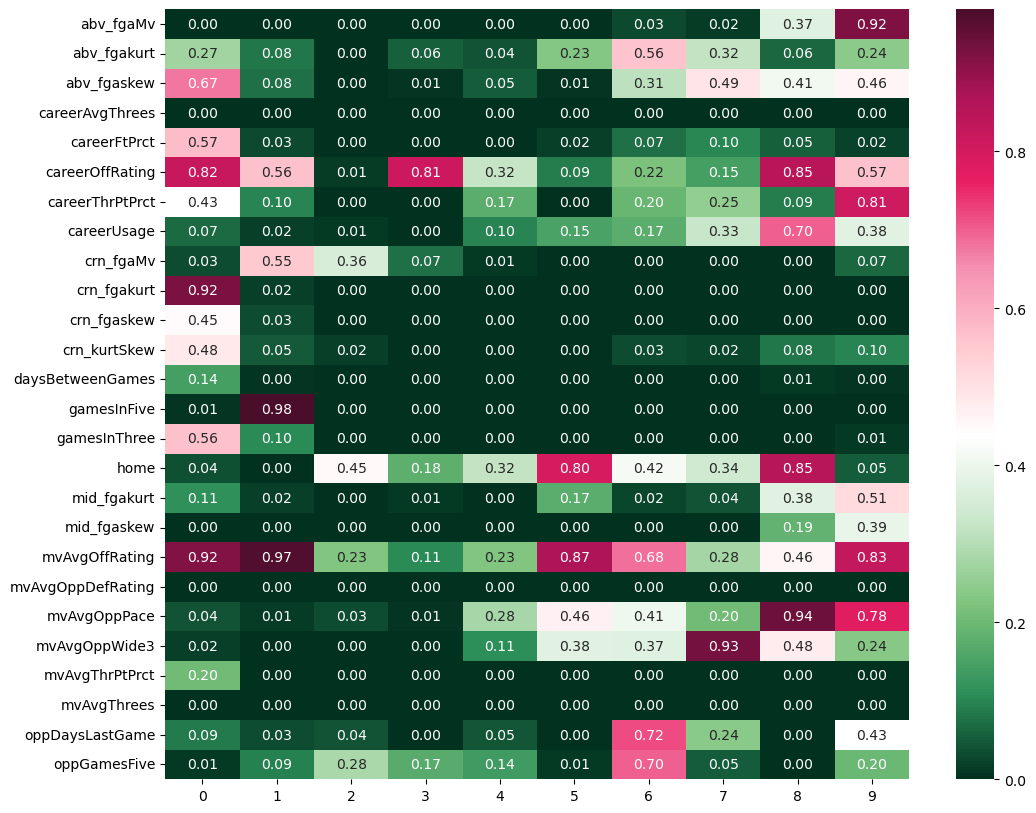

In [966]:
plt.figure(figsize=(12,10))
sns.heatmap(threeMod.pvalues.sort_index(),fmt = '.2f',annot=True,cmap=etl.vlog)
plt.show()

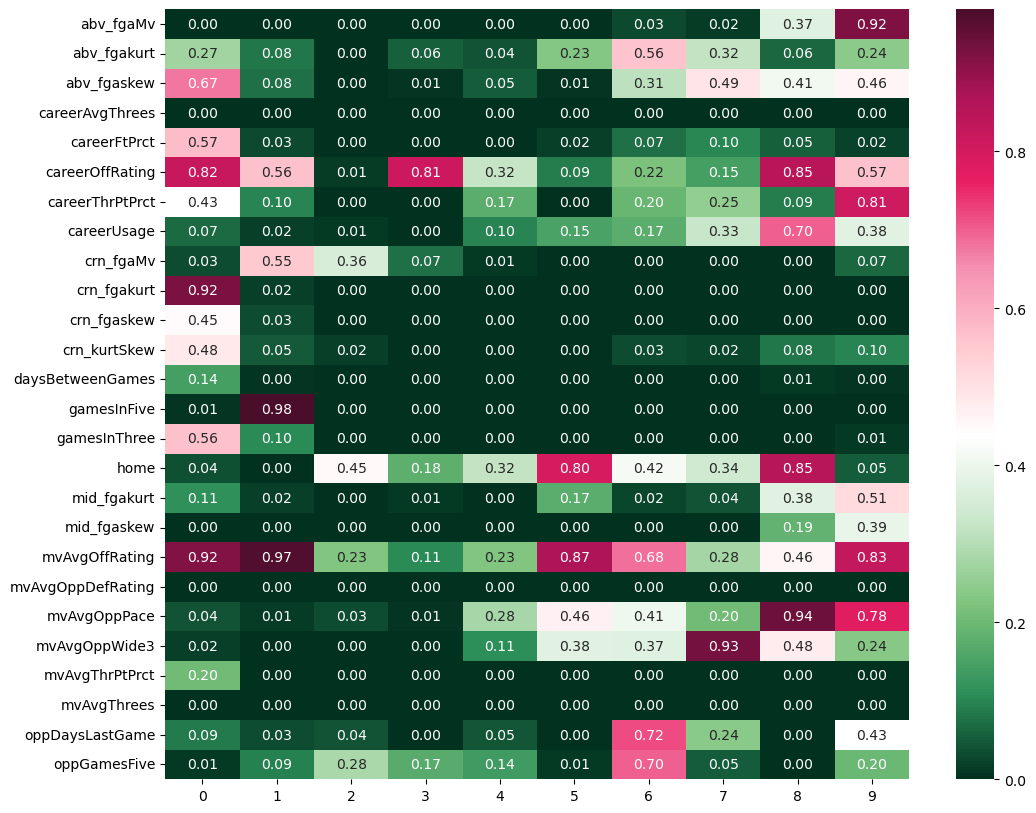

In [1205]:
plt.figure(figsize=(12,10))
sns.heatmap(threeMod.pvalues.sort_index(),fmt = '.2f',annot=True,cmap=etl.vlog)
plt.show()

In [1208]:
thrData = pd.DataFrame(thrData)

In [1749]:
## We need to create a run function to create out dataset and be ready to predict for each model, will start with threes. 
# Layout is already set up above
threeData = pd.DataFrame().from_dict(models.data.get('threes'))
threeData = threeData.merge(data.rolling_player_shot(threeData),how='left',on=['game_date','player_id'])
test = threeData[threeData.game_date>'2024-10-01']


test = test.join(data.weighted_moving_avg(test,5,15,'crn_fga','player_id'))
test = test.join(data.weighted_moving_avg(test,5,15,'abv_fga','player_id'))
test['abv_kurtSkew'] = test.abv_fgakurt * test.abv_fgaskew
test['crn_kurtSkew'] = test.crn_fgakurt * test.crn_fgaskew


In [1822]:
X, ybin, Xtest,yTbin,d = model_data(threeData)

/var/folders/29/0dqpwvqj4095gxyj5dkvym7r0000gn/T/ipykernel_22471/3663836601.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['abv_kurtSkew'] = X.abv_fgakurt * X.abv_fgaskew
/var/folders/29/0dqpwvqj4095gxyj5dkvym7r0000gn/T/ipykernel_22471/3663836601.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['crn_kurtSkew'] = X.crn_fgakurt * X.crn_fgaskew
/var/folders/29/0dqpwvqj4095gxyj5dkvym7r0000gn/T/ipykernel_22471/3663836601.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

In [1819]:
scaleData = threeData[threeData.season.between('2021-22','2023-24')]
scaleData = scaleData.join(data.weighted_moving_avg(scaleData,5,15,'crn_fga','player_id'))
scaleData = scaleData.join(data.weighted_moving_avg(scaleData,5,15,'abv_fga','player_id'))
scaleData['abv_kurtSkew'] = scaleData.abv_fgakurt * scaleData.abv_fgaskew
scaleData['crn_kurtSkew'] = scaleData.crn_fgakurt * scaleData.crn_fgaskew
for col in threeMod.params.index:
    if col.lower().find('kurt|daysBetweenGames|')>-1:
        scaleData[col] = rbiq.fit_transform(scaleData[col].values.reshape(-1,1))
        d[col] = {'center':rbiq.center_,'scale':rbiq.scale_}
    elif col not in ['home','gamesInFive','gamesInThree','oppGamesFive','daysBetweenGames',]:
        scaleData[col] = ss.fit_transform(scaleData[col].values.reshape(-1,1))
        d[col] = {'center':ss.mean_,'scale':ss.var_**.5}

In [1744]:
threeData.oppDaysLastGame.describe()

count    104646.000000
mean          1.279906
std           4.685877
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         145.000000
Name: oppDaysLastGame, dtype: float64

In [1821]:
threeScaler = d

In [1491]:
threeScaler = pd.read_pickle('../nba/data/model/scalVals.pkl')

In [ ]:
iqRobust = RobustScaler()
onRobust = RobustScaler(quantile_range=(10,90))
sns.histplot(threeData['abv_fgakurt'])
plt.show()
d = iqRobust.fit_transform(threeData['abv_fgakurt'].values.reshape(-1,1))
d1 =  onRobust.fit_transform(threeData['abv_fgakurt'].values.reshape(-1,1))
sns.histplot(d)
plt.show()
sns.histplot(d1)

In [2173]:
modData = data.threes_pipe(threes.data)

In [2180]:
getattr(data,'{}_pipe'.format(threes.name))(threes.data)

,threesMade,name,player_id,game_id,game_date,season,team,height,exp,age,...,crn_fgallowedMv,abv_fgallowedMv,wide_fg3allowedcoefVar,abv_kurtSkew,crn_kurtSkew,crn_fgaMv,abv_fgaMv,minFirstcoefVar,abvFgaFirstcoefVar,crnFgaFirstcoefVar
0,0,Kevon Looney,1626172,0022100002,2021-10-19,2021-22,GSW,81.0,6.0,25.689254,...,6.533333,22.933333,0.284824,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4,Pat Connaughton,1626192,0022100001,2021-10-19,2021-22,MIL,77.0,6.0,28.772074,...,7.800000,30.666667,0.257296,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,Damion Lee,1627814,0022100002,2021-10-19,2021-22,GSW,78.0,4.0,28.982888,...,6.533333,22.933333,0.284824,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,Malik Monk,1628370,0022100002,2021-10-19,2021-22,LAL,75.0,4.0,23.693361,...,6.666667,28.066667,0.224561,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3,Grayson Allen,1628960,0022100001,2021-10-19,2021-22,MIL,76.0,3.0,26.020534,...,7.800000,30.666667,0.257296,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79148,0,Dante Exum,203957,0022401194,2025-04-13,2024-25,DAL,77.0,10.0,29.259411,...,10.066667,31.333333,0.276840,-0.439420,0.334288,0.933333,1.600000,0.378636,2.226063,2.638993
79149,1,Bogdan Bogdanovic,203992,0022401198,2025-04-13,2024-25,LAC,77.0,10.0,32.158795,...,8.466667,26.333333,0.287437,-0.220677,-0.101634,0.533333,3.133333,0.585747,1.851640,1.716516
79150,1,Jusuf Nurkic,203994,0022401187,2025-04-13,2024-25,CHA,84.0,10.0,30.146475,...,9.733333,29.533333,0.274532,0.158951,58.094750,0.066667,1.533333,0.466211,1.581139,NaN
79151,3,Nikola Jokic,203999,0022401193,2025-04-13,2024-25,DEN,83.0,10.0,29.653662,...,10.733333,24.533333,0.391800,-0.335438,-0.863756,0.266667,5.066667,0.406159,0.981981,2.638993


In [2182]:
Xtrain, ytrain, Xtest, ytest = models.model_data(threes,'2024-10-01','threesMade',10)

TypeError: data.threes_pipe() missing 1 required positional argument: 'self'

In [ ]:
data

In [2172]:

pd.options.display.max_rows=100
modData.describe(np.arange(.1,1,.1)).T

,count,mean,std,min,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
threesMade,79153.0,1.417723,1.570357,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,2.000000,3.000000,4.000000,13.000000
height,79153.0,78.461170,3.115096,68.000000,74.000000,76.000000,77.000000,77.000000,78.000000,79.000000,80.000000,81.000000,83.000000,88.000000
exp,79153.0,8.748866,83.092687,0.000000,1.000000,2.000000,3.000000,3.000000,4.000000,6.000000,7.000000,9.000000,11.000000,2024.000000
age,79153.0,26.781305,7.215243,18.809035,21.204654,22.600958,23.624914,24.646133,25.785079,27.049966,28.580424,30.376454,32.583162,124.785763
crn_fga,79153.0,0.963855,1.183092,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,2.000000,3.000000,10.000000
abv_fga,79058.0,2.918060,2.736635,0.000000,0.000000,0.000000,1.000000,2.000000,2.000000,3.000000,4.000000,5.000000,7.000000,22.000000
minFirst,56668.0,7.068367,2.565272,0.000000,3.566667,4.666667,5.633333,6.483333,7.266667,7.987000,8.616667,9.264667,10.150000,12.000000
crnFgaFirst,56668.0,0.246506,0.523126,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,6.000000
abvFgaFirst,56668.0,0.773311,1.025776,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,2.000000,9.000000
daysBetweenGames,79153.0,1.645269,2.049154,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,3.000000,10.000000


In [1736]:
for col in threeMod.params.index:
    try:
        print(threeData[threeData.season>='2021-22'][col].describe(np.arange(.1,1,.1)))
        plt.figure(figsize=(5,5))
        sns.histplot(threeData[col].values)
        if threeData[col].quantile(.9) * 3 < threeData[col].quantile(.9):
            
        plt.show()
        print('\n')
    except:
        print('No column:',col)

IndentationError: expected an indented block after 'if' statement on line 6 (1609061235.py, line 8)

In [1718]:
drops = ['mvAvgOppDefRating']z

Optimization terminated successfully.
         Current function value: 1.708342
         Iterations: 399
         Function evaluations: 401
         Gradient evaluations: 401
cumlative brier score of:  0.700
brier score of:  0.718
Mean Score 0.709
0     0.279
1     0.285
2     0.200
3     0.116
4     0.062
5     0.031
6     0.014
7     0.008
8     0.002
9     0.002
10    0.001
dtype: float64

Cumlative Sum of Above
10    0.001
9     0.002
8     0.005
7     0.012
6     0.027
5     0.057
4     0.120
3     0.236
2     0.436
1     0.721
0     1.000
dtype: float64


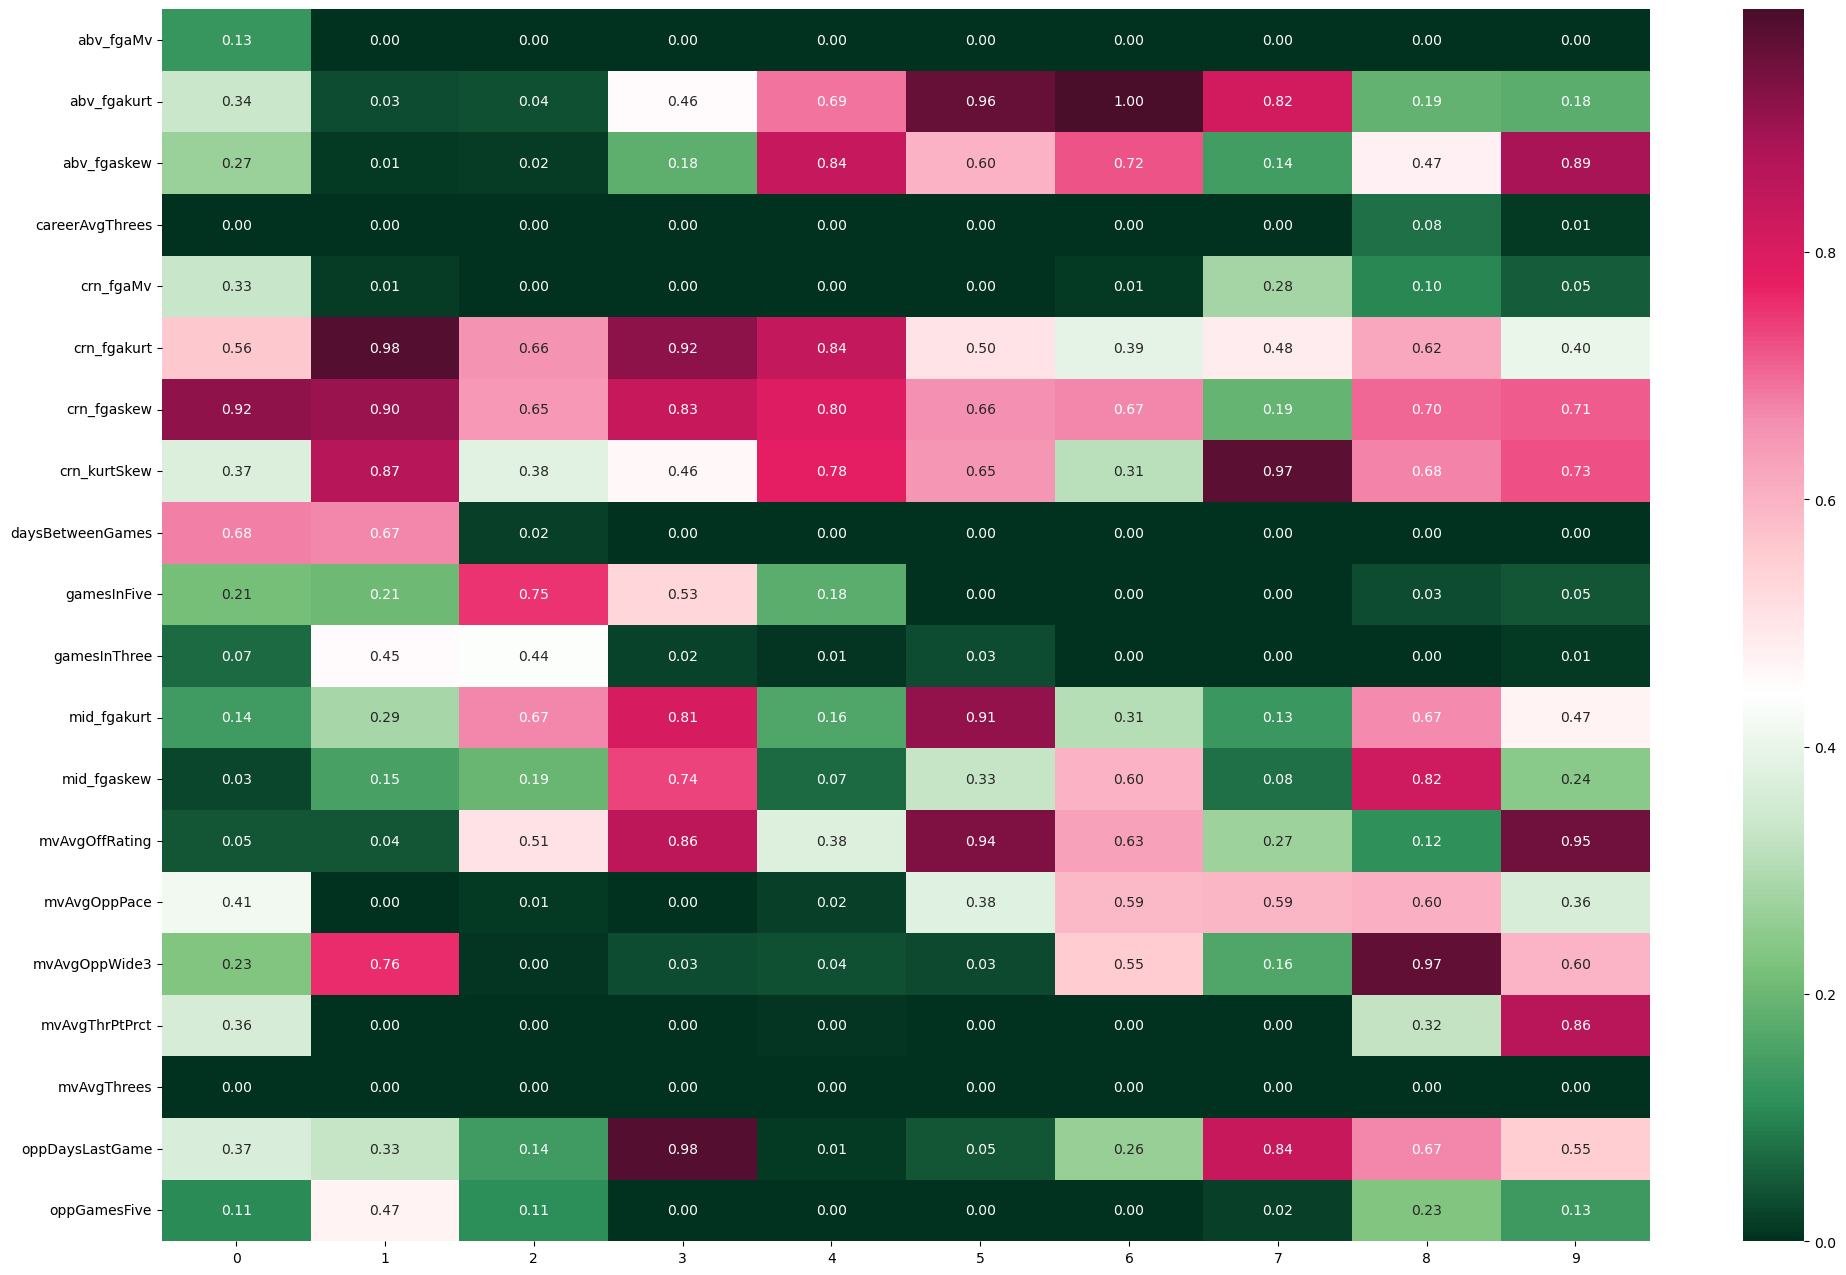

In [1796]:
chk = modTesting(ybin,yTbin,sm.add_constant(X),sm.add_constant(Xtest),[p for p in params if p not in drops],method = 'bfgs')

In [1962]:
X.columns

Index(['threesMade', 'name', 'player_id', 'game_id', 'game_date', 'team',
       'height', 'exp', 'age', 'ra_fga', 'paint_fga', 'mid_fga', 'crn_fga',
       'abv_fga', 'daysBetweenGames', 'gamesInFive', 'gamesInThree',
       'oppGamesFive', 'oppGamesThree', 'oppDaysLastGame', 'tmGameCt',
       'Starter', 'plyrGameCt', 'mvAvgstart', 'mvAvgThrees', 'mvAvgUsage',
       'mvAvgOffRating', 'mvAvgFtPrct', 'mvAvgThrPtPrct', 'seasonUsage',
       'seasonOffRating', 'seasonFtPrct', 'seasonThrPtPrct', 'careerFtPrct',
       'careerThrPtPrct', 'careerUsage', 'careerOffRating', 'careerAvgThrees',
       'opp_id', 'mvAvgOppPace', 'mvAvgOppOpen3', 'mvAvgOppWide3',
       'mvAvgOppDefRating', 'seasonOppPace', 'seasonOppOpen3',
       'seasonOppWide3', 'seasonOppDefRating', 'ra_fgaskew', 'ra_fgakurt',
       'paint_fgaskew', 'paint_fgakurt', 'mid_fgaskew', 'mid_fgakurt',
       'crn_fgaskew', 'crn_fgakurt', 'abv_fgaskew', 'abv_fgakurt',
       'abv_kurtSkew', 'crn_kurtSkew', 'crn_fgaMv', 'abv_fgaMv'

In [1917]:
etl.showTables

,type,name,tbl_name,rootpage,sql
0,table,rosters,rosters,4,"CREATE TABLE rosters(\n teamId TEXT,\n s..."
1,table,players,players,2,"CREATE TABLE players(\n player_id TEXT,..."
2,table,teams,teams,6,"CREATE TABLE teams(\n team_id TEXT,\n te..."
3,table,plyrLogs,plyrLogs,123,"CREATE TABLE plyrLogs (player_id TEXT,\nteam_i..."
4,view,team_game,team_game,0,"CREATE VIEW team_game as \nSELECT season, game..."
5,table,shotsAllowed,shotsAllowed,582,"CREATE TABLE shotsAllowed (team_id TEXT,\ngame..."
6,view,team_def,team_def,0,"CREATE VIEW team_def AS\nselect \nseason, subs..."
7,table,teamLog,teamLog,7,"CREATE TABLE teamLog(\n game_id TEXT,\n..."
8,table,preds,preds,11580,CREATE TABLE preds\n (game_...
9,view,pgames,pgames,0,CREATE VIEW pgames \n AS\nSELECT \n--identi...


In [1943]:
import nba_api.stats.endpoints

In [1961]:
nba_api.stats.endpoints.BoxScorePlayerTrackV3('0021600001').get_data_frames()[0]

,gameId,teamId,teamCity,teamName,teamTricode,teamSlug,personId,firstName,familyName,nameI,...,contestedFieldGoalsMade,contestedFieldGoalsAttempted,contestedFieldGoalPercentage,uncontestedFieldGoalsMade,uncontestedFieldGoalsAttempted,uncontestedFieldGoalsPercentage,fieldGoalPercentage,defendedAtRimFieldGoalsMade,defendedAtRimFieldGoalsAttempted,defendedAtRimFieldGoalPercentage
0,0021600001,1610612752,New York,Knicks,NYK,knicks,2546,Carmelo,Anthony,C. Anthony,...,2,5,0.400,6,13,0.462,0.444,2,3,0.667
1,0021600001,1610612752,New York,Knicks,NYK,knicks,204001,Kristaps,Porziņģis,K. Porziņģis,...,2,5,0.400,3,8,0.375,0.385,5,5,1.000
2,0021600001,1610612752,New York,Knicks,NYK,knicks,201149,Joakim,Noah,J. Noah,...,0,1,0.000,0,0,0.000,0.000,0,0,0.000
3,0021600001,1610612752,New York,Knicks,NYK,knicks,201584,Courtney,Lee,C. Lee,...,0,2,0.000,0,3,0.000,0.000,1,2,0.500
4,0021600001,1610612752,New York,Knicks,NYK,knicks,201565,Derrick,Rose,D. Rose,...,3,9,0.333,4,8,0.500,0.412,1,2,0.500
5,0021600001,1610612752,New York,Knicks,NYK,knicks,201943,Brandon,Jennings,B. Jennings,...,0,0,0.000,1,7,0.143,0.143,3,3,1.000
6,0021600001,1610612752,New York,Knicks,NYK,knicks,203124,Kyle,O'Quinn,K. O'Quinn,...,1,1,1.000,0,2,0.000,0.333,4,7,0.571
7,0021600001,1610612752,New York,Knicks,NYK,knicks,202498,Lance,Thomas,L. Thomas,...,0,1,0.000,1,3,0.333,0.250,2,2,1.000
8,0021600001,1610612752,New York,Knicks,NYK,knicks,203200,Justin,Holiday,J. Holiday,...,0,2,0.000,2,5,0.400,0.286,1,3,0.333
9,0021600001,1610612752,New York,Knicks,NYK,knicks,1626195,Willy,Hernangomez,W. Hernangomez,...,1,1,1.000,1,2,0.500,0.667,0,2,0.000


In [1942]:
from nba_api.stats.endpoints import BoxScoreSummaryV1

ImportError: cannot import name 'BoxScoreSummaryV1' from 'nba_api.stats.endpoints' (/opt/anaconda3/lib/python3.11/site-packages/nba_api/stats/endpoints/__init__.py)

In [1941]:
BoxScoreSummaryV1('0022401189').get_data_frames()[2]

,OFFICIAL_ID,FIRST_NAME,LAST_NAME,JERSEY_NUM


In [1915]:
##new features 
#get team information
q = '''
SELECT AVG(pts) OVER (PARTITION BY player_id ORDER BY game_date ROWS BETWEEN 83 PRECEDING and 1 PRECEDING)
'''

,threesMade,name,player_id,game_id,game_date,season,team,height,exp,age,...,ra_fgaskew,ra_fgakurt,paint_fgaskew,paint_fgakurt,mid_fgaskew,mid_fgakurt,crn_fgaskew,crn_fgakurt,abv_fgaskew,abv_fgakurt
0,2,Channing Frye,101112,0021600001,2016-10-25,2016-17,CLE,84,11,33.415469,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Manu Ginobili,1938,0021600003,2016-10-25,2016-17,SAS,78,17,39.216975,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,Kevin Durant,201142,0021600003,2016-10-25,2016-17,GSW,83,9,28.043806,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,Kevin Love,201567,0021600001,2016-10-25,2016-17,CLE,80,8,28.104038,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,Courtney Lee,201584,0021600001,2016-10-25,2016-17,NYK,77,8,31.033539,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106387,0,Dante Exum,203957,0022401194,2025-04-13,2024-25,DAL,77,10,29.259411,...,2.094311,5.660079,0.498346,-0.333927,0.802288,-0.126680,1.046716,0.319368,0.478778,-0.917794
106388,1,Bogdan Bogdanovic,203992,0022401198,2025-04-13,2024-25,LAC,77,10,32.158795,...,1.046716,0.319368,0.919454,0.736712,1.478766,2.444494,0.802288,-0.126680,0.208119,-1.060342
106389,1,Jusuf Nurkic,203994,0022401187,2025-04-13,2024-25,CHA,84,10,30.146475,...,1.176354,3.255175,1.256033,1.390866,1.176354,-0.734266,3.872983,15.000000,0.771869,0.205930
106390,3,Nikola Jokic,203999,0022401193,2025-04-13,2024-25,DEN,83,10,29.653662,...,0.280789,1.623858,0.108420,-0.576408,0.612898,1.249324,1.176354,-0.734266,0.291995,-1.148781


In [1912]:
params = [p for p in params if p not in drops]
zinb = ZeroInflatedNegativeBinomialP(
    endog=np.array(ybin),
    exog = sm.add_constant(X.filter(params)),
    exog_infl = sm.add_constant(X.filter(params)),
    inflation = 'probit',
    p=2)
zinbFit = zinb.fit(method='bfgs',maxiter=5000)



Optimization terminated successfully.
         Current function value: 1.706702
         Iterations: 228
         Function evaluations: 237
         Gradient evaluations: 237


In [1913]:
max_threes = 10 
zpreds = Xtest[['name','game_date']]

for k in range(0,max_threes + 1):
    preds = zinbFit.predict(
        exog=sm.add_constant(Xtest.filter(params)),
        exog_infl=sm.add_constant(Xtest.filter(params)),
        which='prob',
        y_values=np.array([k])
    )
    
    zpreds = zpreds.join(preds.rename(columns = {0:k}))

In [ ]:
#lu dort looking for about 14 probability around .475
#Bane around around 13 probability around .4935
kellyCrit(0.43380,130) * 125

In [1914]:
brierScore(zpreds.filter(np.arange(0,11)),yTbin,zinbFit)

cumlative brier score of:  0.694
brier score of:  0.709
Mean Score 0.702
0     0.295
1     0.267
2     0.205
3     0.121
4     0.061
5     0.029
6     0.013
7     0.006
8     0.003
9     0.001
10    0.000
dtype: float64

Cumlative Sum of Above
10    0.000
9     0.002
8     0.004
7     0.010
6     0.023
5     0.052
4     0.113
3     0.234
2     0.438
1     0.705
0     1.000
dtype: float64


IndexError: Inconsistent shape between the condition and the input (got (43, 1) and (43,))

<Figure size 2400x1600 with 0 Axes>

In [1864]:
p.columns

Index(['name', 'game_date', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype='object')

In [1789]:
cPreds = chk.predict(Xtest.filter(chk.params.index))
cload =  Xtest[['game_date','game_id','player_id','name','team']].join(cPreds)
cload[(cload.game_date=='2025-03-29') & (cload.name.isin(['Luguentz Dort','Desmond Bane']))][np.arange(3,11)].sum(axis=1)

In [1627]:
preds = threeMod.predict(X.filter(threeMod.params.index))
upload =  test[['game_date','game_id','player_id','name','team']].join(preds)

In [1790]:
cload[(cload.game_date=='2025-03-29') & (cload.name.isin(['Luguentz Dort','Desmond Bane']))][np.arange(3,11)].sum(axis=1)

104468    0.413552
104479    0.419825
dtype: float64

In [1896]:
#lu dort looking for about 14 probability around .475
#Bane around around 13 probability around .4935
kellyCrit(0.43380,130) * 125

-0.21730769230769026

In [1448]:
moddf[(moddf.bet_info.str.startswith('Luguentz Dort')) | (moddf.bet_info.str.startswith('Desmond Bane'))]

,bet_id,sportsbook,type,status,odds,closing_line,ev,amount,profit,time_placed,time_settled,bet_info,tags,sports,leagues
42,EX5497525951W,Bet365,parlay,SETTLED_PUSH,10.08,NaN,NaN,2.00,0.00,04/09/2025 10:57:00 GMT,04/10/2025 03:10:00 GMT,Luguentz Dort: 3+ Threes Made Threes Made OKC ...,ModPlay,Basketball,NBA
43,KX7499339801W,Bet365,parlay,SETTLED_PUSH,3.20,NaN,NaN,2.50,0.00,04/09/2025 10:57:00 GMT,04/10/2025 03:10:00 GMT,Luguentz Dort: 3+ Threes Made Threes Made OKC ...,ModPlay,Basketball,NBA
45,FX9920124321W,Bet365,straight,SETTLED_VOID,2.30,NaN,NaN,7.00,0.00,04/09/2025 10:56:00 GMT,04/10/2025 03:10:00 GMT,Luguentz Dort: 3+ Threes Made Threes Made OKC ...,ModPlay,Basketball,NBA
85,O/0586450/0002968,Fanduel Sportsbook,straight,SETTLED_WIN,2.62,2.63,-0.0019,5.00,8.10,04/06/2025 11:54:22 GMT,04/06/2025 21:00:00 GMT,Luguentz Dort 3+ Made Threes Los Angeles Laker...,ModPlay,Basketball,NBA
136,GX2744744811W,Bet365,parlay,SETTLED_WIN,5.63,5.84,-0.0354,9.25,42.88,03/29/2025 12:17:00 GMT,03/30/2025 00:10:00 GMT,Luguentz Dort: 3+ Threes Made Threes Made IND ...,ModPlay,Basketball,NBA
137,AX1947284601W,Bet365,parlay,SETTLED_WIN,20.25,17.27,0.1722,5.50,105.88,03/29/2025 12:18:00 GMT,03/30/2025 00:10:00 GMT,Desmond Bane: 4+ Threes Made Threes Made LA La...,ModPlay,Basketball,NBA
138,QX7407767681W,Bet365,parlay,SETTLED_WIN,80.75,NaN,NaN,2.00,159.50,03/29/2025 12:19:00 GMT,03/30/2025 00:10:00 GMT,Luguentz Dort: 5+ Threes Made Threes Made IND ...,ModPlay,Basketball,NBA
139,SX5619496503W,Bet365,straight,SETTLED_WIN,8.50,NaN,NaN,6.00,45.00,03/29/2025 12:11:00 GMT,03/30/2025 00:10:00 GMT,Desmond Bane: 5+ Threes Made Threes Made LA La...,ModPlay,Basketball,NBA
140,CX4021936413W,Bet365,straight,SETTLED_WIN,9.50,7.81,0.2165,7.00,59.50,03/29/2025 12:16:00 GMT,03/30/2025 00:10:00 GMT,Luguentz Dort: 5+ Threes Made Threes Made IND ...,ModPlay,Basketball,NBA
142,CX4021936412W,Bet365,straight,SETTLED_WIN,4.50,3.98,0.1300,11.25,39.38,03/29/2025 12:16:00 GMT,03/30/2025 00:10:00 GMT,Luguentz Dort: 4+ Threes Made Threes Made IND ...,ModPlay,Basketball,NBA


In [641]:
d = {}
for col in threeScaler.keys():
    d[col] = {'mean':X[col].mean(),'std':X[col].std()}
    X[col] = (X[col] - X[col].mean()) / X[col].std()
    

In [643]:
pickle.dump(d,open('../nba/data/model/updatedFeats.pkl','wb'))

In [644]:
X = models.scaleDataStand(X,d)
Xtest = models.scaleDataStand(Xtest,d)

In [1217]:
params = ['abv_fgaMv','abv_fgakurt','abv_fgaskew','careerAvgThrees','crn_fgaMv','crn_fgakurt','crn_kurtSkew','daysBetweenGames',
          'gamesInFive','gamesInThree','home','mid_fgakurt','mid_fgaskew','mvAvgOffRating','mvAvgOppDefRating','mvAvgOppPace',
          'mvAvgOppWide3','mvAvgThrees','oppDaysLastGame','oppGamesFive']

In [ ]:
newMod = modTesting(ybin, yTbin, X, Xtest, params)

In [1199]:
newPreds = newMod.predict(Xtest.filter(newMod.params.index))
newUp =  Xtest[['game_date','game_id','player_id','name','team']].join(newPreds)

In [1223]:
newUp[newUp.name=='Desmond Bane'].round(2).tail(15)

,game_date,game_id,player_id,name,team,0,1,2,3,4,5,6,7,8,9,10
102569,2025-03-14,0022400962,1630217,Desmond Bane,MEM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
102719,2025-03-15,0022400971,1630217,Desmond Bane,MEM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
102988,2025-03-17,0022400992,1630217,Desmond Bane,MEM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
103236,2025-03-19,0022401008,1630217,Desmond Bane,MEM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
103482,2025-03-21,0022401023,1630217,Desmond Bane,MEM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
103991,2025-03-25,0022401050,1630217,Desmond Bane,MEM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
104230,2025-03-27,0022401064,1630217,Desmond Bane,MEM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
104479,2025-03-29,0022401078,1630217,Desmond Bane,MEM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
104731,2025-03-31,0022401093,1630217,Desmond Bane,MEM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
104858,2025-04-01,0022401100,1630217,Desmond Bane,MEM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [419]:
bdf = pd.read_csv('../nba/data/csv/24-25Bets.csv')

In [421]:
moddf = bdf[bdf.tags.fillna('None').str.contains('ModPlay')].reset_index(drop=True)

In [683]:
moddf[moddf.bet_info.str.contains('Dort')]

,bet_id,sportsbook,type,status,odds,closing_line,ev,amount,profit,time_placed,time_settled,bet_info,tags,sports,leagues
42,EX5497525951W,Bet365,parlay,SETTLED_PUSH,10.08,NaN,NaN,2.00,0.00,04/09/2025 10:57:00 GMT,04/10/2025 03:10:00 GMT,Luguentz Dort: 3+ Threes Made Threes Made OKC ...,ModPlay,Basketball,NBA
43,KX7499339801W,Bet365,parlay,SETTLED_PUSH,3.20,NaN,NaN,2.50,0.00,04/09/2025 10:57:00 GMT,04/10/2025 03:10:00 GMT,Luguentz Dort: 3+ Threes Made Threes Made OKC ...,ModPlay,Basketball,NBA
44,XX5318497271W,Bet365,parlay,SETTLED_PUSH,3.15,NaN,NaN,2.50,0.00,04/09/2025 10:58:00 GMT,04/10/2025 03:10:00 GMT,Paolo Banchero: 3+ Threes Made Threes Made BOS...,ModPlay,Basketball,NBA
45,FX9920124321W,Bet365,straight,SETTLED_VOID,2.30,NaN,NaN,7.00,0.00,04/09/2025 10:56:00 GMT,04/10/2025 03:10:00 GMT,Luguentz Dort: 3+ Threes Made Threes Made OKC ...,ModPlay,Basketball,NBA
84,O/0586450/0002970,Fanduel Sportsbook,round_robin_2,SETTLED,NaN,NaN,NaN,10.50,-1.33,04/06/2025 11:54:56 GMT,04/06/2025 21:38:12 GMT,Nick Smith Jr. 3+ Made Threes Chicago Bulls @ ...,ModPlay,Basketball,NBA
85,O/0586450/0002968,Fanduel Sportsbook,straight,SETTLED_WIN,2.62,2.63,-0.0019,5.00,8.10,04/06/2025 11:54:22 GMT,04/06/2025 21:00:00 GMT,Luguentz Dort 3+ Made Threes Los Angeles Laker...,ModPlay,Basketball,NBA
86,O/0586450/0002969,Fanduel Sportsbook,parlay,SETTLED_LOSS,14.87,13.37,0.1122,2.00,0.00,04/06/2025 11:54:22 GMT,04/06/2025 19:31:15 GMT,Nick Smith Jr. 3+ Made Threes Chicago Bulls @ ...,ModPlay,Basketball,NBA
136,GX2744744811W,Bet365,parlay,SETTLED_WIN,5.63,5.84,-0.0354,9.25,42.88,03/29/2025 12:17:00 GMT,03/30/2025 00:10:00 GMT,Luguentz Dort: 3+ Threes Made Threes Made IND ...,ModPlay,Basketball,NBA
137,AX1947284601W,Bet365,parlay,SETTLED_WIN,20.25,17.27,0.1722,5.50,105.88,03/29/2025 12:18:00 GMT,03/30/2025 00:10:00 GMT,Desmond Bane: 4+ Threes Made Threes Made LA La...,ModPlay,Basketball,NBA
138,QX7407767681W,Bet365,parlay,SETTLED_WIN,80.75,NaN,NaN,2.00,159.50,03/29/2025 12:19:00 GMT,03/30/2025 00:10:00 GMT,Luguentz Dort: 5+ Threes Made Threes Made IND ...,ModPlay,Basketball,NBA


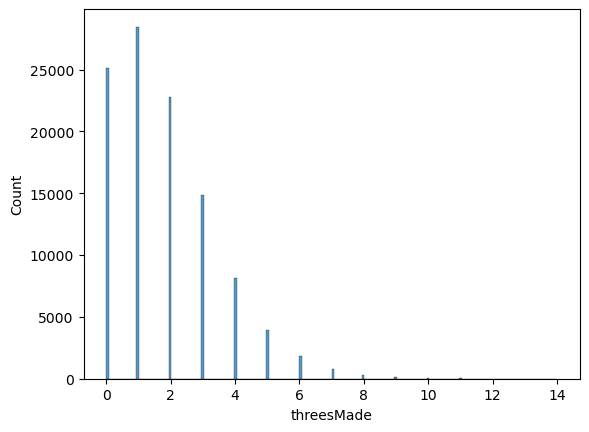

In [1777]:
sns.histplot(threeData.threesMade)
plt.show()

In [501]:
moddf.loc[145]

bet_id                                              SX5619496501W
sportsbook                                                 Bet365
type                                                     straight
status                                                SETTLED_WIN
odds                                                          2.3
closing_line                                                 2.51
ev                                                        -0.0824
amount                                                       13.0
profit                                                       16.9
time_placed                               03/29/2025 12:11:00 GMT
time_settled                              03/30/2025 00:10:00 GMT
bet_info        Desmond Bane: 3+ Threes Made Threes Made LA La...
tags                                                     ModPlay 
sports                                                 Basketball
leagues                                                       NBA
Name: 145,

In [98]:
moddf['date'] = [pd.to_datetime(x[:10]).strftime('%Y-%m-%d') for x in moddf.time_placed]

In [104]:
moddf.ev.describe(np.arange(.1,1,.1))

count    1306.000000
mean        0.012120
std         0.134905
min        -0.348900
10%        -0.124300
20%        -0.081300
30%        -0.055500
40%        -0.031000
50%        -0.005000
60%         0.020400
70%         0.052000
80%         0.098400
90%         0.174950
max         0.960100
Name: ev, dtype: float64

In [111]:
moddf.bet_info[1]

'Julius Randle: 3+ Threes Made Threes Made UTA Jazz @ MIN Timberwolves | Jamal Murray: 4+ Threes Made Threes Made DEN Nuggets @ HOU Rockets'

In [113]:
moddf.type

0         parlay
1         parlay
2         parlay
3       straight
4       straight
          ...   
1817      parlay
1818    straight
1819    straight
1820    straight
1821    straight
Name: type, Length: 1822, dtype: object

In [114]:
moddf[moddf.type=='straight']

,bet_id,sportsbook,type,status,odds,closing_line,ev,amount,profit,time_placed,time_settled,bet_info,tags,sports,leagues,date
3,PA6345029851W,Bet365,straight,SETTLED_LOSS,2.45,2.67,-0.0824,8.50,-8.5,04/13/2025 10:51:00 GMT,04/13/2025 20:40:00 GMT,Jamal Murray: 3+ Threes Made Threes Made DEN N...,ModPlay,Basketball,NBA,2025-04-13
4,PA6345029852W,Bet365,straight,SETTLED_LOSS,1.87,2.05,-0.0880,8.00,-8.0,04/13/2025 10:51:00 GMT,04/13/2025 20:40:00 GMT,Julius Randle: 2+ Threes Made Threes Made UTA ...,ModPlay,Basketball,NBA,2025-04-13
5,SA9933457251W,Bet365,straight,SETTLED_LOSS,3.60,3.65,-0.0128,5.50,-5.5,04/13/2025 10:52:00 GMT,04/13/2025 20:40:00 GMT,Julius Randle: 3+ Threes Made Threes Made UTA ...,ModPlay,Basketball,NBA,2025-04-13
6,SA9933457252W,Bet365,straight,SETTLED_LOSS,4.50,4.69,-0.0396,8.00,-8.0,04/13/2025 10:52:00 GMT,04/13/2025 20:40:00 GMT,Jamal Murray: 4+ Threes Made Threes Made DEN N...,ModPlay,Basketball,NBA,2025-04-13
7,O/0586450/0003026,Fanduel Sportsbook,straight,SETTLED_VOID,2.72,NaN,NaN,7.25,0.0,04/13/2025 10:56:23 GMT,04/13/2025 18:58:17 GMT,Ja Morant 3+ Made Threes Dallas Mavericks @ Me...,ModPlay,Basketball,NBA,2025-04-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1815,638651517117652754,Draftkings Sportsbook,straight,SETTLED_WIN,4.90,NaN,NaN,5.00,19.5,10/21/2024 23:55:12 GMT,10/23/2024 04:41:55 GMT,3+ Nickeil Alexander-Walker Three Pointers Mad...,ModPlay,Basketball,NBA,2024-10-21
1818,638651517132920291,Draftkings Sportsbook,straight,SETTLED_LOSS,1.91,1.96,-0.0267,10.00,-10.0,10/21/2024 23:55:12 GMT,10/23/2024 01:50:00 GMT,2+ Payton Pritchard Three Pointers Made NY Kni...,ModPlay,Basketball,NBA,2024-10-21
1819,638651517117673978,Draftkings Sportsbook,straight,SETTLED_LOSS,3.65,NaN,NaN,5.00,-5.0,10/21/2024 23:55:12 GMT,10/23/2024 01:50:00 GMT,3+ Payton Pritchard Three Pointers Made NY Kni...,ModPlay,Basketball,NBA,2024-10-21
1820,638651517117482436,Draftkings Sportsbook,straight,SETTLED_LOSS,7.00,8.44,-0.1709,5.00,-5.0,10/21/2024 23:55:12 GMT,10/23/2024 01:47:49 GMT,3+ Josh Hart Three Pointers Made NY Knicks @ B...,ModPlay,Basketball,NBA,2024-10-21


In [118]:

moddf[['ev','odds','profit']].corr()

,ev,odds,profit
ev,1.000000,0.083807,0.052417
odds,0.083807,1.000000,0.003356
profit,0.052417,0.003356,1.000000


In [122]:

moddf[moddf.type=='straight'][['ev','odds','profit']].corr()

,ev,odds,profit
ev,1.000000,0.365474,0.152994
odds,0.365474,1.000000,0.054973
profit,0.152994,0.054973,1.000000


In [131]:
##split out bets to be more readable
len([x for x in moddf.bet_info if x.find(':')==-1])

1012

In [135]:
moddf[moddf.bet_info.str.contains(':')].sportsbook.value_counts()

sportsbook
Bet365    785
BetMGM     25
Name: count, dtype: int64

In [139]:

moddf[(~moddf.bet_info.str.contains(':')) & (moddf.sportsbook.str.startswith('B'))]

,bet_id,sportsbook,type,status,odds,closing_line,ev,amount,profit,time_placed,time_settled,bet_info,tags,sports,leagues,date
27,201BS8T042,BetMGM,parlay,SETTLED_LOSS,21.87,17.99,0.2154,3.00,-3.00,04/10/2025 11:24:52 GMT,04/11/2025 04:40:00 GMT,Yes Tobias Harris to make 2+ three-pointers Ne...,ModPlay,Basketball,NBA,2025-04-10
28,201BS8T03F,BetMGM,straight,SETTLED_LOSS,6.25,6.12,0.0204,3.00,-3.00,04/10/2025 11:24:52 GMT,04/11/2025 04:40:00 GMT,Yes Scotty Pippen to make 3+ three-pointers Mi...,ModPlay,Basketball,NBA,2025-04-10
35,201BS8SZZ6,BetMGM,straight,SETTLED_WIN,3.50,2.94,0.1914,3.00,7.50,04/10/2025 11:24:52 GMT,04/11/2025 01:09:58 GMT,Yes Tobias Harris to make 2+ three-pointers Ne...,ModPlay,Basketball,NBA,2025-04-10
39,201B08Y6D2,BetMGM,straight,SETTLED_LOSS,3.10,3.09,0.0023,10.00,-10.00,04/09/2025 22:04:27 GMT,04/10/2025 05:10:00 GMT,Yes Keldon Johnson to make 2+ three-pointers S...,ModPlay,Basketball,NBA,2025-04-09
40,201B08Y6CE,BetMGM,straight,SETTLED_LOSS,8.00,NaN,NaN,6.50,-6.50,04/09/2025 22:04:27 GMT,04/10/2025 05:10:00 GMT,Yes Keldon Johnson to make 3+ three-pointers S...,ModPlay,Basketball,NBA,2025-04-09
68,BX1831210141W,Bet365,straight,SETTLED_WIN,2.60,2.59,0.0039,9.00,14.40,04/08/2025 16:33:00 GMT,04/09/2025 00:30:00 GMT,Jalen Brunson - Over 2.5 Threes Made O/U BOS C...,ModPlay,Basketball,NBA,2025-04-08
157,CX8783963002W,Bet365,straight,SETTLED_LOSS,2.20,2.27,-0.0308,10.00,-10.00,03/27/2025 16:55:00 GMT,03/28/2025 00:10:00 GMT,Jaren Jackson Jr - Under 1.5 Threes Made O/U M...,ModPlay,Basketball,NBA,2025-03-27
163,200P1FJWJ7,BetMGM,straight,SETTLED_LOSS,3.40,3.31,0.0276,8.40,-8.40,03/26/2025 18:23:52 GMT,03/27/2025 02:02:47 GMT,Yes Scottie Barnes to make 2+ three-pointers T...,ModPlay,Basketball,NBA,2025-03-26
164,200P1FJWPP,BetMGM,straight,SETTLED_WIN,2.65,2.59,0.0232,8.80,14.52,03/26/2025 18:23:52 GMT,03/27/2025 02:02:47 GMT,Yes Rui Hachimura to make 2+ three-pointers Lo...,ModPlay,Basketball,NBA,2025-03-26
165,200P1FJWJU,BetMGM,parlay,SETTLED_LOSS,9.01,8.57,0.0514,5.00,-5.00,03/26/2025 18:23:52 GMT,03/27/2025 02:02:47 GMT,Yes Scottie Barnes to make 2+ three-pointers T...,ModPlay,Basketball,NBA,2025-03-26


In [142]:
moddf[moddf.sportsbook.isin(['DraftKings Sportsbook','FanDuel Sportsbook'])]

,bet_id,sportsbook,type,status,odds,closing_line,ev,amount,profit,time_placed,time_settled,bet_info,tags,sports,leagues,date


In [149]:
moddf[(moddf.bet_info.str.contains('Under')) & (moddf.sportsbook=='Draftkings Sportsbook')].loc[1494].bet_info

'2+ Keldon Johnson Three Pointers Made SA Spurs @ SAC Kings | Under 1.5 Rui Hachimura Three Pointers Made O/U LA Lakers @ UTA Jazz | Under 3.5 Dalton Knecht Three Pointers Made O/U LA Lakers @ UTA Jazz'

In [ ]:
moddf.

In [ ]:
def convertPikkit(df,value):
    '''
    Take Pikkit download extract: player name, game date, value, book, odds and wining to format to be saved in db.
    Inputs: df of the pikkit data, value - this is the market (ie Threes, Points) to save down
    Output: Dataframe that will replicate what is now stored in the db.
    '''



In [151]:
odds = pd.read_csv('

type
parlay           3508.75
round_robin_2     293.22
round_robin_3     -13.25
round_robin_4      -0.50
straight         1075.92
Name: profit, dtype: float64

In [35]:
import os
import glob
import datetime as dt

In [154]:
thrs = pd.read_pickle('data/nbaData/2024-25pointsThrees.pkl')
fb = pd.read_pickle('data/nbaData/2024-25firstBasketspm.pkl')


In [155]:
test = list(fb.items())[:100]

In [377]:
import json

In [161]:
test

[('0_0',
  {'id': 'a7d6bf35d58918099f6a139a4e67908d',
   'sport_key': 'basketball_nba',
   'sport_title': 'NBA',
   'commence_time': '2025-03-27T23:00:00Z',
   'home_team': 'Cleveland Cavaliers',
   'away_team': 'San Antonio Spurs',
   'bookmakers': [{'key': 'draftkings',
     'title': 'DraftKings',
     'last_update': '2025-03-27T21:55:08Z',
     'markets': [{'key': 'player_first_basket',
       'last_update': '2025-03-27T21:55:59Z',
       'outcomes': [{'name': 'Yes',
         'description': 'Jarrett Allen',
         'price': 550},
        {'name': 'Yes', 'description': 'Chris Paul', 'price': 1400},
        {'name': 'Yes', 'description': 'Devin Vassell', 'price': 700},
        {'name': 'Yes', 'description': 'Dean Wade', 'price': 1500},
        {'name': 'Yes', 'description': 'Harrison Barnes', 'price': 1000},
        {'name': 'Yes', 'description': 'Donovan Mitchell', 'price': 400},
        {'name': 'Yes', 'description': 'Bismack Biyombo', 'price': 1200},
        {'name': 'Yes', 'descr

In [202]:
df = pd.DataFrame()
missing = []
idx = ['description','date','name','mrkt',]
#first basket needs a different idx because it does not have point
mkts = ['threes','points','player_first_basket','player_first_team_basket','spread']
for t in tqdm(list(fb.items())):
    try:
        home = t[1].get('home_team')
        away = t[1].get('away_team')
        date = (pd.to_datetime(t[1].get('commence_time')) - dt.timedelta(hours = 4)).strftime('%Y-%m-%d')
        for books in t[1].get('bookmakers'):
            bk = books.get('key')
            for mrkts in books.get('markets'):
                d = mrkts.get('outcomes')
                m = mrkts.get('key')
                temp = pd.DataFrame(d)
                alt = 'alt' if m.find('alt')>-1 else 'OU'
                temp['date'] = date
                temp = temp.rename(columns = {'price':'{}_{}_price'.format(bk,alt)} if m.find('basket')==-1 else {'price':'{}'.format(bk)})
                temp['mrkt'] = [l for l in m.split('_') if l in mkts][0] if m.find('basket')==-1 else m
                df = pd.concat([df,temp.groupby(idx).max()])
    except:
      missing.append(t)  


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1805/1805 [00:07<00:00, 256.83it/s]


In [204]:
df

,,,,draftkings,fanduel
description,date,name,mrkt,,
Bismack Biyombo,2025-03-27,Yes,player_first_basket,1200.0,NaN
Chris Paul,2025-03-27,Yes,player_first_basket,1400.0,NaN
Darius Garland,2025-03-27,Yes,player_first_basket,500.0,NaN
Dean Wade,2025-03-27,Yes,player_first_basket,1500.0,NaN
Devin Vassell,2025-03-27,Yes,player_first_basket,700.0,NaN
...,...,...,...,...,...
Myles Turner,2025-01-25,Yes,player_first_basket,NaN,900.0
Pascal Siakam,2025-01-25,Yes,player_first_basket,NaN,700.0
Stephon Castle,2025-01-25,Yes,player_first_basket,NaN,650.0


In [205]:
names = ['fanduel','draftkings','betmgm','espnbet']
mkts = ['threes','points','player_first_basket','player_first_team_basket','spread']
for book in names:
    try:
        df[book] = df['{}_OU_price'.format(book)].fillna(df['{}_alt_price'.format(book)])
    except:
        print('No {} odds'.format(book))
df = df.groupby(idx).min().filter(names).reset_index()
for m in mkts:
    temp = df[df.mrkt.str.contains(m)].drop(['mrkt'],axis=1)

    

No fanduel odds
No draftkings odds
No betmgm odds
No espnbet odds


In [207]:
temp = df.reset_index()[df.reset_index().mrkt.str.contains('basket')].drop(['mrkt'],axis=1)
cols = [r[1] for r in nba.cur.execute('PRAGMA table_info(oddsFirstBasket)').fetchall()]
d = zip(temp.columns,cols)
temp = temp.rename(columns = dc)
for c in cols:
    if c not in temp.columns:
        temp[c] = None

In [210]:
nba.insert_data(temp.filter(cols),'oddsFirstBasket')

oddsFirstBasket has been updated with 12,701 rows


In [487]:
fb = pd.read_pickle('data/nbaData/2024-25firstBasketspm.pkl')

In [483]:
pd.read_sql('select * from oddsThrees',nba.conn).columns

Index(['name', 'game_date', 'side', 'amount', 'FDOdds', 'DKOdds', 'ESPNOdds',
       'MGMOdds', 'ModelOdds', 'betPlaced', 'betAmount', 'betBook'],
      dtype='object')

In [394]:
dk = df.loc['Devin Vassell'].draftkings_OU_price.fillna(df.loc['Devin Vassell'].draftkings_alt_price).to_frame('draftkings').dropna()
fd = df.loc['Devin Vassell'].fanduel_OU_price.fillna(df.loc['Devin Vassell'].fanduel_alt_price).to_frame('fanduel').dropna()

In [367]:
df.loc['Zion Williamson'].loc['2025-03-24'].head(50)

draftkings_alt_price  fanduel_alt_price  \
name  point mrkt                                                               
Over  14.5  player_points_alternate               -1800.0            -1600.0   
      17.5  player_points_alternate                -700.0                0.0   
      19.5  player_points_alternate                -425.0             -350.0   
      24.5  player_points_alternate                -135.0             -122.0   
      25.5  player_points_alternate                -115.0                0.0   
      29.5  player_points_alternate                 180.0              220.0   
      34.5  player_points_alternate                 450.0              500.0   
      39.5  player_points_alternate                1200.0             1060.0   
      44.5  player_points_alternate                3000.0             2000.0   
      25.5  player_points                             NaN                NaN   
Under 25.5  player_points                             NaN                NaN   
Over  14.5  player_points_alternate               -1800.0            -1600.0   
      17.5  player_points_alternate                -700.0                0.0   
      19.5  player_points_alternate                -425.0             -350.0   
      24.5  player_points_alternate                -135.0             -122.0   
      25.5  player_points_alternate                -115.0                0.0   
      29.5  player_points_alternate                 180.0              220.0   
      34.5  player_points_alternate                 450.0              500.0   
      39.5  player_points_alternate                1200.0             1060.0   
      44.5  player_points_alternate                3000.0             2000.0   
      25.5  player_points                             NaN                NaN   
Under 25.5  player_points                             NaN                NaN   
Over  14.5  player_points_alternate               -1800.0            -1600.0   
      17.5  player_points_alternate                -700.0                0.0   
      19.5  player_points_alternate                -425.0             -350.0   
      24.5  player_points_alternate                -135.0             -122.0   
      25.5  player_points_alternate                -115.0                0.0   
      29.5  player_points_alternate                 180.0              220.0   
      34.5  player_points_alternate                 450.0              500.0   
      39.5  player_points_alternate                1200.0             1060.0   
      44.5  player_points_alternate                3000.0             2000.0   
      25.5  player_points                             NaN                NaN   
Under 25.5  player_points                             NaN                NaN   
Over  14.5  player_points_alternate               -1800.0            -1600.0   
      17.5  player_points_alternate                -700.0                0.0   
      19.5  player_points_alternate                -425.0             -350.0   
      24.5  player_points_alternate                -135.0             -122.0   
      25.5  player_points_alternate                -115.0                0.0   
      29.5  player_points_alternate                 180.0              220.0   
      34.5  player_points_alternate                 450.0              500.0   
      39.5  player_points_alternate                1200.0             1060.0   
      44.5  player_points_alternate                3000.0             2000.0   
      25.5  player_points                             NaN                NaN   
Under 25.5  player_points                             NaN                NaN   
Over  14.5  player_points_alternate               -1800.0            -1600.0   
      17.5  player_points_alternate                -700.0                0.0   
      19.5  player_points_alternate                -425.0             -350.0   
      24.5  player_points_alternate                -135.0             -122.0   
      25.5  player_points_alternate  

In [13]:
nba.showTables

,type,name,tbl_name,rootpage,sql
0,table,rosters,rosters,4,"CREATE TABLE rosters(\n teamId TEXT,\n s..."
1,table,players,players,2,"CREATE TABLE players(\n player_id TEXT,..."
2,table,teams,teams,6,"CREATE TABLE teams(\n team_id TEXT,\n te..."
3,table,plyrLogs,plyrLogs,123,"CREATE TABLE plyrLogs (player_id TEXT,\nteam_i..."
4,view,team_game,team_game,0,"CREATE VIEW team_game as \nSELECT season, game..."
5,table,shotsAllowed,shotsAllowed,582,"CREATE TABLE shotsAllowed (team_id TEXT,\ngame..."
6,view,team_def,team_def,0,"CREATE VIEW team_def AS\nselect \nseason, subs..."
7,table,teamLog,teamLog,7,"CREATE TABLE teamLog(\n game_id TEXT,\n..."
8,table,preds,preds,11580,CREATE TABLE preds\n (game_...
9,view,pgames,pgames,0,CREATE VIEW pgames \n AS\nSELECT \n--identi...


In [21]:
pd.read_sql('select * from oddsThrees',nba.conn).columns

Index(['name', 'game_date', 'side', 'amount', 'FDOdds', 'DKOdds', 'ESPNOdds',
       'MGMOdds', 'ModelOdds', 'betPlaced', 'betAmount', 'betBook'],
      dtype='object')

In [20]:
df.rename({'description':'name','date':'game_date','name':'side','point':'amount','fanduel':'FDOdds','draftkings':'DKOdds',

,description,date,name,mrkt,point,draftkings_OU_price,draftkings_alt_price,fanduel_OU_price,fanduel_alt_price,fanduel,draftkings
0,Chris Paul,2025-03-27,Over,player_points,6.5,-105.0,NaN,NaN,NaN,NaN,-105.0
1,Chris Paul,2025-03-27,Under,player_points,6.5,-125.0,NaN,NaN,NaN,NaN,-125.0
2,Darius Garland,2025-03-27,Over,player_points,20.5,-110.0,NaN,NaN,NaN,NaN,-110.0
3,Darius Garland,2025-03-27,Under,player_points,20.5,-120.0,NaN,NaN,NaN,NaN,-120.0
4,Devin Vassell,2025-03-27,Over,player_points,19.5,-110.0,NaN,NaN,NaN,NaN,-110.0
...,...,...,...,...,...,...,...,...,...,...,...
555266,Victor Wembanyama,2025-01-25,Over,player_threes_alternate,3.5,NaN,NaN,NaN,105.0,105.0,NaN
555267,Victor Wembanyama,2025-01-25,Over,player_threes_alternate,4.5,NaN,NaN,NaN,220.0,220.0,NaN
555268,Victor Wembanyama,2025-01-25,Over,player_threes_alternate,5.5,NaN,NaN,NaN,460.0,460.0,NaN
555269,Victor Wembanyama,2025-01-25,Over,player_threes_alternate,6.5,NaN,NaN,NaN,800.0,800.0,NaN


In [7]:
games = nba.get_games('2022-10-01','2025-04-20')

In [4]:
cols = [r[1] for r in nba.cur.execute('PRAGMA table_info(plyrLogs)').fetchall()]

In [1101]:
games.GAME_DATE.nunique()

487

In [ ]:
shts = pd.DataFrame()
for i in range(7):
    
    g = games.GAME_DATE.unique()[75*i:75*(i+1)]
    temp = etl.get_player_shot_spots(g)
    shts = pd.concat([shts,temp])
    time.sleep(1254)

In [ ]:
g = games.GAME_DATE.unique()[-75:]
temp = etl.get_player_shot_spots(g)
shts = pd.concat([shts,temp])

In [1109]:
shts = shts.drop_duplicates().reset_index()

In [23]:
from nba_api.stats.endpoints import BoxScoreAdvancedV3

In [31]:
import time
gs = games[games.GAME_DATE<='2024-03-21'].GAME_DATE.unique()

In [68]:
pd.DataFrame(pd.read_pickle('../nba/data/pickle/plyrShots2022-23.pkl'))

,PLAYER_ID,TEAM_ID,Restricted_Area_FGM,Restricted_Area_FGA,In_The_Paint_(Non_RA)_FGM,In_The_Paint_(Non_RA)_FGA,Mid_Range_FGM,Mid_Range_FGA,Left_Corner_3_FGM,Left_Corner_3_FGA,Right_Corner_3_FGM,Right_Corner_3_FGA,Above_the_Break_3_FGM,Above_the_Break_3_FGA,GAME_DATE,GAME_ID
0,1631260,1610612749,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,2.0,0.0,1.0,2023-04-05,NaN
1,1631100,1610612737,0.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,2.0,3.0,3.0,2023-04-05,NaN
2,1628988,1610612737,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2023-04-05,NaN
3,1630174,1610612754,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,3.0,2023-04-05,NaN
4,203458,1610612758,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-04-05,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,202083,1610612749,2.0,2.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,2.0,2023-04-05,NaN
160,203115,1610612761,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,1.0,2023-04-05,NaN
161,1641645,1610612764,2.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-04-05,NaN
162,1629139,1610612751,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,2023-04-05,NaN


In [199]:
adv = pd.DataFrame()
for season in seasons:
    time.sleep(25)
    temp = PlayerGameLogs(season_nullable=season,measure_type_player_game_logs_nullable= 'Advanced',
                          season_type_nullable='Regular Season').get_data_frames()[0]
    temp = temp.filter(['GAME_ID','PLAYER_ID','OFF_RATING','DEF_RATING','USG_PCT','PACE','POSS'])
    adv = pd.concat([adv,temp])
    time.sleep(45)
fb_ = etl.get_first_buckets(games[games.GAME_DATE.between('2022-10-01','2024-10-01')].GAME_DATE.unique())

In [205]:
log = pd.DataFrame()
for season in seasons:
    temp = PlayerGameLogs(season_nullable=season,season_type_nullable='Regular Season').get_data_frames()[0]
    temp = temp.filter(['PLAYER_ID','TEAM_ID','GAME_ID','GAME_DATE','MIN','FTM','FTA','REB',
			'AST','TOV','STL','BLK','BLKA','PF','PFD','PTS','PLUS_MINUS', 'DD2','TD3'])
    log = pd.concat([log,temp])

In [846]:
rbs = pd.DataFrame()

for i,day in enumerate(missing):
    rbsCols = ['PLAYER_ID','TEAM_ID','OREB','OREB_CONTEST','OREB_CHANCES','OREB_CHANCE_DEFER','AVG_OREB_DIST',
    			'DREB','DREB_CONTEST','DREB_CHANCES','DREB_CHANCE_DEFER','AVG_DREB_DIST']
    temp = LeagueDashPtStats(pt_measure_type='Rebounding',player_or_team='Player',
        date_from_nullable = day,
        date_to_nullable = day,
        season = etl.derive_season(day),
        per_mode_simple='Totals'
    ).get_data_frames()[0][rbsCols]
    temp['game_date'] = day
    rbs = pd.concat([rbs,temp])
    if np.random.randint(1,100) % 7 ==0:
        time.sleep(np.random.randint(8,49))
    # if i %100==0:
    #     time.sleep(600)

In [1179]:



logrbs = log.merge(r.drop(['TEAM_ID'],axis=1), how='left', on=['PLAYER_ID', 'GAME_DATE']).fillna(0)
logRbsSht = logrbs.merge(shts.drop(['TEAM_ID'],axis=1), how='left', on=[ 'PLAYER_ID', 'GAME_DATE'])
advBskt = adv.merge(firstbuckets, how='left', on=['PLAYER_ID', 'GAME_ID'])
final = logRbsSht.merge(advBskt, how='left', on=['PLAYER_ID', 'GAME_ID'])
final['Starter'] = 0

final.columns = ['player_id', 'team_id', 'game_id', 'game_date', 'min', 'ftm', 'fta', 'reb', 'ast', 'tov',
                 'stl', 'blk', 'blka', 'pf',
                 'pfd', 'pts', 'plus_minus', 'dd2', 'td3', 'oreb', 'oreb_contest', 'oreb_chances',
                 'oreb_chance_defer', 'avg_oreb_dist', 'dreb',
                 'dreb_contest', 'dreb_chances', 'dreb_chance_defer', 'avg_dreb_dist', 'ra_fgm', 'ra_fga',
                 'paint_fgm', 'paint_fga', 'mid_fgm',
                 'mid_fga', 'lc_fgm', 'lc_fga', 'rc_fgm', 'rc_fga', 'abv_fgm', 'abv_fga', 'offensiveRating',
                 'defensiveRating',
                 'usagePercentage', 'pace', 'possessions', 'team_first', 'game_first', 'Starter']

In [1173]:
pd.read_sql('select * from plyrLogs limit 1',etl.conn).columns

Index(['player_id', 'team_id', 'game_id', 'game_date', 'min', 'ftm', 'fta',
       'reb', 'ast', 'tov', 'stl', 'blk', 'blka', 'pf', 'pfd', 'pts',
       'plus_minus', 'dd2', 'td3', 'offensiveRating', 'defensiveRating',
       'usagePercentage', 'pace', 'possessions', 'team_first', 'game_first',
       'oreb', 'oreb_contest', 'oreb_chances', 'oreb_chance_defer',
       'avg_oreb_dist', 'dreb', 'dreb_contest', 'dreb_chances',
       'dreb_chance_defer', 'avg_dreb_dist', 'ra_fgm', 'ra_fga', 'paint_fga',
       'paint_fgm', 'mid_fgm', 'mid_fga', 'lc_fgm', 'lc_fga', 'rc_fgm',
       'rc_fga', 'abv_fgm', 'abv_fga', 'Starter'],
      dtype='object')

In [1164]:
shts.abv_fga.describe()

count    78108.000000
mean         2.493381
std          2.646938
min          0.000000
25%          0.000000
50%          2.000000
75%          4.000000
max         22.000000
Name: abv_fga, dtype: float64

In [1161]:
final[final.abv_fga==22]

,player_id,team_id,game_id,game_date,min,ftm,fta,reb,ast,tov,...,abv_fgm,abv_fga,offensiveRating,defensiveRating,usagePercentage,pace,possessions,team_first,game_first,Starter
36570,201939,1610612744,0022300699,2024-02-03,41.35,6,6,6,4,2,...,10.0,22.0,119.8,123.6,0.398,104.47,91,NaN,NaN,0


In [932]:
pCols = [col[0] for col in etl.cur.execute('SELECT * from plyrLogs limit 1').description]

In [1004]:
r[r.PLAYER_ID==1630217].merge(shots[shots.PLAYER_ID==1630217],how='left'

'2022-12-23'

In [1055]:
final.game_date.min()

'2022-10-18'

In [1177]:
ord = [col[0] for col in etl.cur.execute('select * from {} limit 1'.format('plyrLogs')).description ]

In [1180]:
etl.cur.execute("DELETE FROM plyrLogs where game_date > '2022-10-01'")
etl.conn.commit()
etl.insert_data(final,'plyrLogs')

plyrLogs has been updated with 78,601 rows


In [1087]:
test[test.player_id.isin([str(x) for x in lkups])].name.unique()

array(['Miles McBride', 'Jeff Dowtin Jr.', 'Tre Mann', 'Moussa Diabate',
       'AJ Johnson', 'Aaron Wiggins', 'Cole Swider', 'Micah Potter',
       'Oscar Tshiebwe'], dtype=object)

In [1093]:
temp = etl.get_player_shot_spots(['2025-03-19'])

start player shots at 21:00


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.18s/it]

completed player shots at 21:00


In [1094]:
temp[temp.PLAYER_ID==1631131]

,PLAYER_ID,TEAM_ID,ra_fgm,ra_fga,paint_fgm,paint_fga,mid_fgm,mid_fga,lc_fgm,lc_fga,rc_fgm,rc_fga,abv_fgm,abv_fga,GAME_DATE
168,1631131,1610612762,1.0,3.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,2025-03-19


In [1170]:
pd.read_sql("select * from plyrLogs where game_date > '2024-10-01'",etl.conn)

,player_id,team_id,game_id,game_date,min,ftm,fta,reb,ast,tov,...,paint_fgm,mid_fgm,mid_fga,lc_fgm,lc_fga,rc_fgm,rc_fga,abv_fgm,abv_fga,Starter
0,1631213,1610612751,0022401188,2025-04-13,31.333333,2,2,7,1,6,...,2.0,4.0,104.6,106.0,0.300,101.11,65,NaN,NaN,0
1,1641763,1610612741,0022401191,2025-04-13,26.100000,0,0,7,2,0,...,0.0,2.0,122.0,90.0,0.121,109.43,59,NaN,NaN,0
2,1642259,1610612764,0022401190,2025-04-13,15.533333,3,4,8,4,0,...,1.0,2.0,130.3,121.2,0.222,101.97,33,NaN,NaN,0
3,1642367,1610612761,0022401197,2025-04-13,34.916667,1,2,14,10,2,...,0.0,3.0,117.1,109.0,0.193,105.85,76,NaN,NaN,0
4,1631106,1610612745,0022401193,2025-04-13,17.933333,0,1,7,3,1,...,0.0,0.0,89.2,145.9,0.255,99.03,37,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26301,1629674,1610612738,0022400061,2024-10-22,4.333333,0,0,0,0,0,...,0.0,0.0,25.0,25.0,0.000,88.62,8,NaN,NaN,0
26302,1629216,1610612747,0022400062,2024-10-22,17.216667,0,0,2,2,2,...,0.0,0.0,110.8,126.5,0.089,98.97,37,NaN,NaN,0
26303,1627759,1610612738,0022400061,2024-10-22,29.900000,4,4,7,1,1,...,4.0,8.0,161.4,121.1,0.323,91.51,57,NaN,NaN,0
26304,1628401,1610612738,0022400061,2024-10-22,26.631667,2,2,3,4,0,...,3.0,7.0,170.6,129.4,0.250,91.92,51,NaN,NaN,0


In [1168]:
thrData.columns

Index(['threesMade', 'name', 'player_id', 'game_id', 'game_date', 'team',
       'height', 'exp', 'age', 'ra_fga', 'paint_fga', 'mid_fga', 'crn_fga',
       'abv_fga', 'daysBetweenGames', 'gamesInFive', 'gamesInThree',
       'oppGamesFive', 'oppGamesThree', 'oppDaysLastGame', 'home',
       'plyrGameCt', 'tmGameCt', 'Starter', 'plyrfirst10', 'mvAvgstart',
       'mvAvgThrees', 'mvAvgUsage', 'mvAvgOffRating', 'mvAvgFtPrct',
       'mvAvgThrPtPrct', 'seasonUsage', 'seasonOffRating', 'seasonFtPrct',
       'seasonThrPtPrct', 'careerFtPrct', 'careerThrPtPrct', 'careerUsage',
       'careerOffRating', 'careerAvgThrees', 'opp_id', 'mvAvgOppPace',
       'mvAvgOppOpen3', 'mvAvgOppWide3', 'mvAvgOppDefRating', 'seasonOppPace',
       'seasonOppOpen3', 'seasonOppWide3', 'seasonOppDefRating', 'crn_fgaMv',
       'abv_fgaMv'],
      dtype='object')